In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "August2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [3]:
model_list

[<Model Human-GEM_28062023 at 0x25a492ccf10>,
 <Model mod_RPE_PRcone_Liang at 0x25a51f90490>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x25a1497d870>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x25a1e07aaa0>,
 <Model mod_RPE_PRcone_Lukowski at 0x25a3862b8b0>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x25a853504f0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x25a8b5d23e0>,
 <Model mod_RPE_PRcontrol at 0x25a3a70c070>,
 <Model mod_RPE_PRrod_Liang at 0x25af3ecbd30>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x25af7f6de70>,
 <Model mod_RPE_PRrod_Liang_singlePRE at 0x25afd1eebf0>,
 <Model mod_RPE_PRrod_Lukowski at 0x25b020a3460>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x25b09a7f670>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x25b0e114340>]

In [4]:
# select only models containing Lukowski in their name 
model_list = [model for model in model_list if 'Lukowski' in model.id \
                        or 'Human-GEM' in model.id\
                        or 'control' in model.id]
model_list

[<Model Human-GEM_28062023 at 0x25a492ccf10>,
 <Model mod_RPE_PRcone_Lukowski at 0x25a3862b8b0>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x25a853504f0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x25a8b5d23e0>,
 <Model mod_RPE_PRcontrol at 0x25a3a70c070>,
 <Model mod_RPE_PRrod_Lukowski at 0x25b020a3460>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x25b09a7f670>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x25b0e114340>]

In [87]:
# modify models
# load blood exchange bounds

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
        m.reactions.get_by_id('MAR03964_PR').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
        m.reactions.get_by_id('MAR03964_RPE').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
        m.reactions.get_by_id('MAR03964').bounds = (-1000,1000)
        m.objective.direction = 'max'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# allow all metabolites out (open efflux) and open influx for water
for m in model_list:
    for r in [r for r in m.reactions if len(r.products) == 0]:
        r.bounds = (0,0)
    for r in [r for r in m.reactions if len(r.products) == 0  if '_eRPE_PR' not in r.id]:  # open efflux for exchange reactions (except for with the RPE-PR[e] interface)
        r.bounds=(0,1000)
    for r in [r for r in m.reactions if 'MAR09047' in r.id and '_eRPE_PR' not in r.id]: # MAR09047: water
        r.bounds=(-1000,1000) 

In [6]:
print('list of H2O exchange reactions in model at position 1 in model_list:')
[r for r in model_list[1].reactions if 'MAR09047' in r.id]

list of H2O exchange reactions in model at position 1 in model_list:


[<Reaction MAR09047_RPE at 0x25a80269090>,
 <Reaction MAR09047_eRPE_PR at 0x25a812d0d90>,
 <Reaction MAR09047_PR at 0x25a83f67310>]

In [84]:
print('H2O exchange bounds with PR: ' + str(model_list[1].reactions.get_by_id('MAR09047_PR').bounds))
print('H2O exchange bounds with RPE: ' + str(model_list[1].reactions.get_by_id('MAR09047_RPE').bounds))
print('H2O exchange bounds with RPE-PR interface: ' + str(model_list[1].reactions.get_by_id('MAR09047_eRPE_PR').bounds))

H2O exchange bounds with PR: (-1000, 1000)
H2O exchange bounds with RPE: (-1000, 1000)
H2O exchange bounds with RPE-PR interface: (0, 0)


In [9]:
single_models

[<Model mod_RPE_PRcone_Lukowski_singlePR at 0x25a853504f0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x25a8b5d23e0>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x25b09a7f670>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x25b0e114340>]

In [10]:
Human1_models

[<Model Human-GEM_28062023 at 0x25a492ccf10>]

In [290]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

##############################################################
#######    total exchange (for single models)        #########
##############################################################

single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                      'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(8.34,8.34)}

single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                       'MAR09034':(-2.05,-2.05),\
                        'MAR09135':(4.21,4.21)}

##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                      'MAR09034_RPE':(-4.14,-4.14),\
                      'MAR09135_RPE':(7.18,7.18),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(-0.67,-0.67),\
                      'MAR09135_PR':(1.16,1.16)}

ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR09034_RPE':(-1.84,-1.84),\
                      'MAR09135_RPE':(3.79,3.79),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(-0.20,-0.20),\
                      'MAR09135_PR':(0.41,0.41)}


##############################################################
##############     for combined models      ##################
##############################################################

results_dict_dark = {}
results_dict_light = {}
for model in combined_models:
    with model as m:
        for ex in ex_bounds_dark.keys(): 
            model.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
        m.optimize()
        results_dict_dark[m.id] = m.objective.value
        for ex in ex_bounds_light.keys(): 
            model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
        m.optimize()
        results_dict_light[m.id] = m.objective.value

df1 = pd.DataFrame(results_dict_dark, index = ['dark']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark']).T
results = pd.concat([df1,df2], axis = 1)

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2)')
results.to_clipboard()
results

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2)


,light,dark
mod_RPE_PRcone_Lukowski,None,27.9
mod_RPE_PRcontrol,None,28.5
mod_RPE_PRrod_Lukowski,None,27.9


In [292]:
results_dict_dark_single = {}
results_dict_light_single = {}


for model in single_models + Human1_models:
    with model as m:
        reactions_list = [r.id for r in m.reactions]
        for ex in single_ex_bounds_dark.keys(): 
            if (ex + '_RPE') in reactions_list:
                model.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
            elif (ex + '_PR') in reactions_list:
                model.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_dark[ex] # set exchange bounds
            elif (ex) in reactions_list:
                model.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
            else:
                print('exchange reaction not found')
        m.optimize()
        results_dict_dark_single[m.id] = m.objective.value
        for ex in single_ex_bounds_light.keys(): 
            if (ex + '_RPE') in reactions_list:
                model.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_light[ex]
            elif (ex + '_PR') in reactions_list:
                model.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_light[ex]
            elif (ex) in reactions_list:
                model.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
            else:   
                print('exchange reaction not found')
        m.optimize()
        results_dict_light_single[m.id] = m.objective.value

df1 = pd.DataFrame(results_dict_light_single, index = ['light']).T
df2 = pd.DataFrame(results_dict_dark_single, index = ['dark']).T
results = pd.concat([df1,df2], axis = 1)

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)')
results.to_clipboard()
results

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)


,light,dark
mod_RPE_PRcone_Lukowski_singlePR,None,25.02
mod_RPE_PRcone_Lukowski_singleRPE,None,26.94
mod_RPE_PRrod_Lukowski_singlePR,None,26.94
mod_RPE_PRrod_Lukowski_singleRPE,None,26.94
Human-GEM_28062023,None,28.30


In [325]:
####################################################################################################
#########                   INVESTIGATE POSSIBLE FEASIBLE SOLUTIONS (LIGHT)           ##############
#########   using lactate and glucose sweeps (oxygen fixed at 2.49 pmol/s/mm^2)       ##############
####################################################################################################

# LACTATE SWEEP

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

multiplication_factors = [round(x * .01, 2) for x in range(70, 101, 1)]

results_dict_light = {}
for model in combined_models:
    objective_values = []
    with model as m:
        for i in multiplication_factors:
            lactate_RPE = 3.79*i
            lactate_PR = 0.41*i
            ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR09034_RPE':(-1.84,-1.84),\
                      'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(-0.20,-0.20),\
                      'MAR09135_PR':(lactate_PR,lactate_PR)}
            for ex in ex_bounds_light.keys(): 
                model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_light[m.id] = objective_values

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2')
df1 = pd.DataFrame(results_dict_light,index=[m*(3.79+0.41) for m in multiplication_factors])

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


,mod_RPE_PRcone_Lukowski,mod_RPE_PRcontrol,mod_RPE_PRrod_Lukowski
2.940,17.67750,17.67750,17.67750
2.982,17.67225,17.67225,17.67225
3.024,17.66700,17.66700,17.66700
3.066,17.66175,17.66175,17.66175
3.108,17.65650,17.65650,17.65650
3.150,17.65125,17.65125,17.65125
3.192,16.89000,17.17800,16.89000
3.234,15.89250,16.55850,15.89250
3.276,14.89500,15.93900,14.89500
3.318,13.89750,15.31950,13.89750


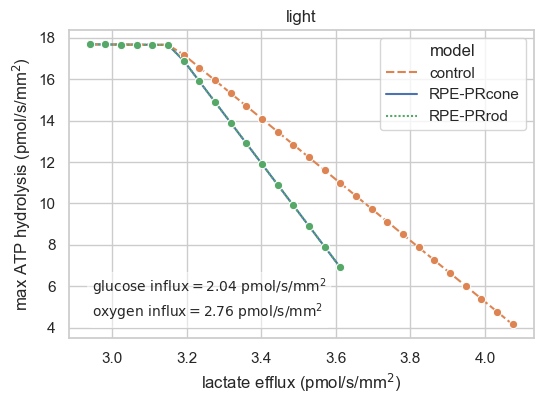

In [326]:
# LACTATE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df1,marker='o',ax=ax)
plt.xlabel('lactate efflux (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('light')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx} = 2.04\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 2.76\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'RPE-PRcone', 'RPE-PRrod']
ax.legend(handles, labels, title='model')

def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'light')
fig.savefig(results_folder + '/light_lactate_sweep.png', bbox_inches='tight')
df1.to_excel(results_folder + '/light_lactate_sweep.xlsx')  

In [353]:
################## DARK ##################
multiplication_factors = [round(x * .01, 2) for x in range(80, 150, 1)]

results_dict_dark = {}
for model in combined_models:
    objective_values = []
    with model as m:
        for i in multiplication_factors:
            lactate_RPE = 7.18*i
            lactate_PR = 1.16*i
            ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                      'MAR09034_RPE':(-4.14,-4.14),\
                      'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(-0.67,-0.67),\
                      'MAR09135_PR':(lactate_PR,lactate_PR)}
            for ex in ex_bounds_dark.keys(): 
                model.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_dark[m.id] = objective_values

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2')
df1_dark = pd.DataFrame(results_dict_dark,index=[m*(7.18+1.16) for m in multiplication_factors])

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


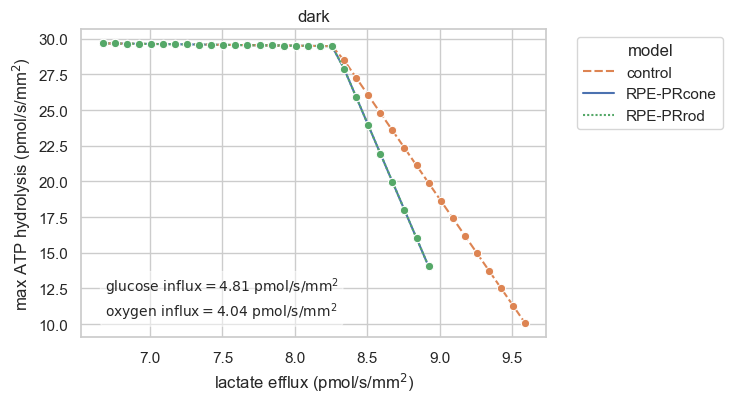

In [354]:
# LACTATE SWEEP FIGURE (DARK)

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df1_dark,marker='o',ax=ax)
plt.xlabel('lactate efflux (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('dark')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx} = 4.81\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 4.04\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'RPE-PRcone', 'RPE-PRrod']
# move legend up a bit
ax.legend(handles, labels, title='model', bbox_to_anchor=(1.05, 1), loc='upper left')

def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'dark')
fig.savefig(results_folder + '/dark_lactate_sweep.png', bbox_inches='tight')
df1_dark.to_excel(results_folder + '/dark_lactate_sweep.xlsx')  

In [328]:
####################################################################################################
#########                   INVESTIGATE POSSIBLE FEASIBLE SOLUTIONS (LIGHT)           ##############
#########   using lactate and glucose sweeps (oxygen fixed at 2.49 pmol/s/mm^2)       ##############
####################################################################################################

# LACTATE SWEEP

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

multiplication_factors = [round(x * .01, 2) for x in range(70, 101, 1)]

results_dict_light = {}

for model in single_models  + Human1_models:
    objective_values = []
    with model as m:
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            lactate = 4.21*i
            single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                        'MAR09034':(-2.05,-2.05),\
                        'MAR09135':(lactate,lactate)}
            for ex in single_ex_bounds_light.keys(): 
                if ex + '_RPE' in reaction_list:
                    model.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_light[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    model.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_light[ex]
                elif ex in reaction_list:
                    model.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_light[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df1_single = pd.DataFrame(results_dict_light,index=[m*(4.21) for m in multiplication_factors])

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


,mod_RPE_PRcone_Lukowski_singlePR,mod_RPE_PRcone_Lukowski_singleRPE,mod_RPE_PRrod_Lukowski_singlePR,mod_RPE_PRrod_Lukowski_singleRPE,Human-GEM_28062023
2.9470,15.891250,17.09650,17.02660,17.09650,17.699125
2.9891,15.838625,17.07545,17.01818,17.07545,17.693862
3.0312,15.786000,17.05440,17.00976,17.05440,17.688600
3.0733,15.733375,17.03335,17.00134,17.03335,17.683338
3.1154,15.680750,17.01230,16.99292,17.01230,17.678075
3.1575,15.628125,16.99125,16.98450,16.99125,17.672812
3.1996,15.178600,16.52920,16.52920,16.52920,17.322100
3.2417,14.273450,15.56090,15.56090,15.56090,16.574825
3.2838,13.368300,14.59260,14.59260,14.59260,15.827550
3.3259,12.463150,13.62430,13.62430,13.62430,15.080275


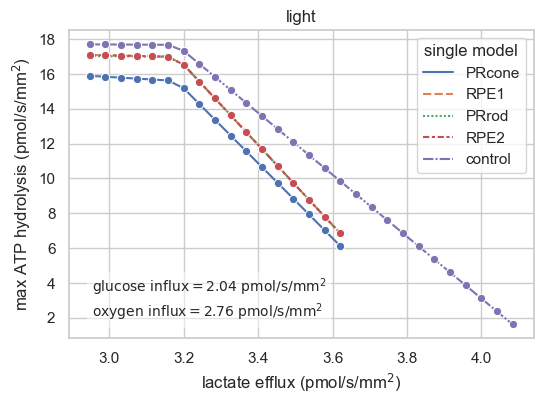

In [329]:
# LACTATE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df1_single,marker='o',ax=ax)
plt.xlabel('lactate efflux (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('light')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx} = 2.04\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 2.76\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
labels = ['PRcone', 'RPE1', 'PRrod','RPE2', 'control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
#ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'light')
fig.savefig(results_folder + '/light_lactate_sweep_SINGLE.png', bbox_inches='tight')
df1.to_excel(results_folder + '/light_lactate_sweep_SINGLE.xlsx')  

In [417]:
####################################################################################################
#########                   INVESTIGATE POSSIBLE FEASIBLE SOLUTIONS (DARK)           ##############
####################################################################################################

# LACTATE SWEEP

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

#             		choroid	retinal	total
#    oxygen influx	3.48	0.56	4.04
#	glucose influx	4.14	0.67	4.81
#	lactate efflux	7.18	1.16	8.34

multiplication_factors = [round(x * .01, 2) for x in range(80, 150, 1)]

results_dict_dark = {}

for model in single_models  + Human1_models:
    objective_values = []
    with model as m:
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            lactate = (8.34)*i
            single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                        'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(lactate,lactate)}
            for ex in single_ex_bounds_dark.keys(): 
                if ex + '_RPE' in reaction_list:
                    model.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    model.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_dark[ex]
                elif ex in reaction_list:
                    model.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_dark[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)')
df1_single_dark = pd.DataFrame(results_dict_dark,index=[m* (7.18+1.16) for m in multiplication_factors])

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)


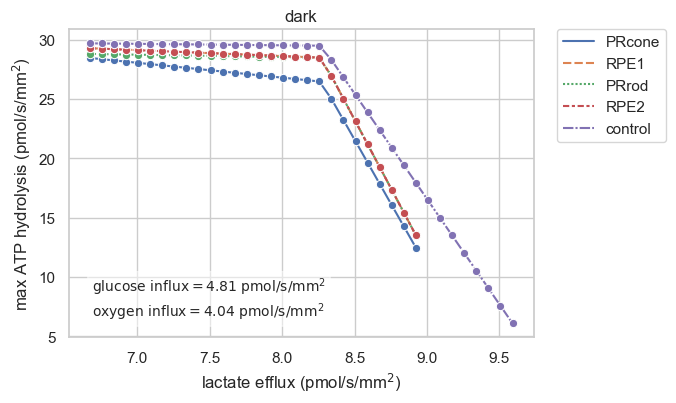

In [418]:
# LACTATE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df1_single_dark,marker='o',ax=ax)
plt.xlabel('lactate efflux (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('dark')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx} = 4.81\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 4.04\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
labels = ['PRcone', 'RPE1', 'PRrod','RPE2', 'control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'dark')
fig.savefig(results_folder + '/dark_lactate_sweep_SINGLE.png', bbox_inches='tight')
df1_single_dark.to_excel(results_folder + '/dark_lactate_sweep_SINGLE.xlsx')  

In [330]:
# GLUCOSE SWEEP

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 


##############################################################
##############     for combined models      ##################
##############################################################

multiplication_factors = [round(x * .01, 2) for x in range(100, 130, 1)]

results_dict_light2 = {}
for model in combined_models:
    objective_values = []
    with model as m:
        for i in multiplication_factors:
            lactate_RPE = 3.79
            lactate_PR = 0.41
            glucose_RPE = -1.84*i
            glucose_PR = -.20*i
            ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
                      'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(glucose_PR,glucose_PR),\
                      'MAR09135_PR':(lactate_PR,lactate_PR)}
            for ex in ex_bounds_light.keys(): 
                model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_light2[m.id] = objective_values

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2 = pd.DataFrame(results_dict_light2,index=[m*(1.84+.20) for m in multiplication_factors])

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


,mod_RPE_PRcone_Lukowski,mod_RPE_PRcontrol,mod_RPE_PRrod_Lukowski
2.0400,NaN,NaN,NaN
2.0604,NaN,NaN,NaN
2.0808,NaN,NaN,NaN
2.1012,NaN,4.2378,NaN
2.1216,NaN,4.8804,NaN
2.1420,NaN,5.5230,NaN
2.1624,NaN,6.1656,NaN
2.1828,NaN,6.8082,NaN
2.2032,NaN,7.4508,NaN
2.2236,NaN,8.0934,NaN


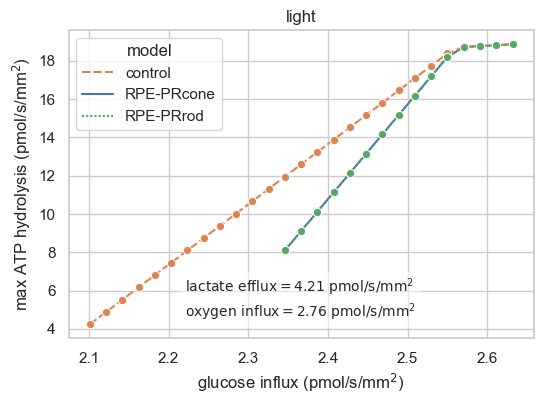

In [331]:
# df1 and df2 plots with seaborn (connected dots, index on x axis)

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2,marker='o',ax=ax)
# add axis titles
plt.xlabel('glucose influx (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('light')
# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux} = 4.21\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 2.76\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.25, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
        
# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'RPE-PRcone', 'RPE-PRrod']
ax.legend(handles, labels, title='model')

# save figure in results folder
results_folder = create_folder('results', 'sweep', 'light')
fig.savefig(results_folder + '/light_glucose_sweep.png', bbox_inches='tight')
df2.to_excel(results_folder + '/light_glucose_sweep.xlsx')  

In [424]:
# GLUCOSE SWEEP

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 
#		          choroid	retinal	total
#    oxygen influx	3.48	0.56	4.04
#	glucose influx	4.14	0.67	4.81
#	lactate efflux	7.18	1.16	8.34


##############################################################
##############     for combined models      ##################
##############################################################

multiplication_factors = [round(x * .01, 2) for x in range(90, 130, 1)]

results_dict_dark2 = {}
for model in combined_models:
    objective_values = []
    with model as m:
        for i in multiplication_factors:
            lactate_RPE = 7.18
            lactate_PR = 1.16
            glucose_RPE = -4.14*i
            glucose_PR = -0.67*i
            ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                      'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
                      'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(glucose_PR,glucose_PR),\
                      'MAR09135_PR':(lactate_PR,lactate_PR)}
            for ex in ex_bounds_dark.keys(): 
                model.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_dark2[m.id] = objective_values

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_dark = pd.DataFrame(results_dict_dark2,index=[m*(4.14 + 0.67) for m in multiplication_factors])

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


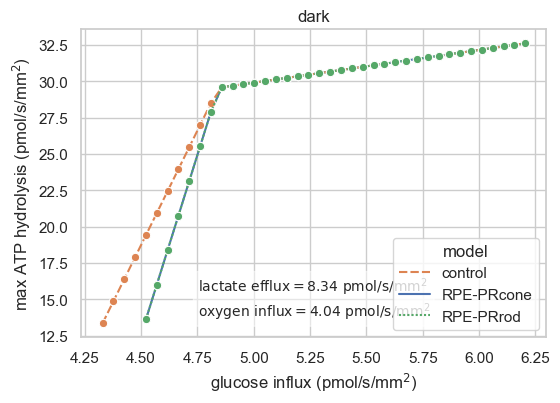

In [425]:
# df1 and df2 plots with seaborn (connected dots, index on x axis)

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2_dark,marker='o',ax=ax)
# add axis titles
plt.xlabel('glucose influx (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('dark')
# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux} = 8.34\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 4.04\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.25, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
        
# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'RPE-PRcone', 'RPE-PRrod']
ax.legend(handles, labels, title='model')

# save figure in results folder
results_folder = create_folder('results', 'sweep', 'dark')
fig.savefig(results_folder + '/dark_glucose_sweep.png', bbox_inches='tight')
df2_dark.to_excel(results_folder + '/dark_glucose_sweep.xlsx')  

In [332]:
# GLUCOSE SWEEP SINGLE MODELS

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

multiplication_factors = [round(x * .01, 2) for x in range(90, 130, 1)]

results_dict_light = {}

for model in single_models + Human1_models:
    objective_values = []
    with model as m:
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            glucose = (-2.04)*i
            single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                        'MAR09034':(glucose,glucose),\
                        'MAR09135':(4.21,4.21)}
            for ex in single_ex_bounds_light.keys(): 
                if ex + '_RPE' in reaction_list:
                    model.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_light[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    model.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_light[ex]
                elif ex in reaction_list:
                    model.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_light[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_single = pd.DataFrame(results_dict_light,index=[m*(2.04) for m in multiplication_factors])


SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2


,mod_RPE_PRcone_Lukowski_singlePR,mod_RPE_PRcone_Lukowski_singleRPE,mod_RPE_PRrod_Lukowski_singlePR,mod_RPE_PRrod_Lukowski_singleRPE,Human-GEM_28062023
1.8360,NaN,NaN,NaN,NaN,NaN
1.8564,NaN,NaN,NaN,NaN,NaN
1.8768,NaN,NaN,NaN,NaN,NaN
1.8972,NaN,NaN,NaN,NaN,NaN
1.9176,NaN,NaN,NaN,NaN,NaN
1.9380,NaN,NaN,NaN,NaN,NaN
1.9584,NaN,NaN,NaN,NaN,NaN
1.9788,NaN,NaN,NaN,NaN,NaN
1.9992,NaN,NaN,NaN,NaN,NaN
2.0196,NaN,NaN,NaN,NaN,NaN


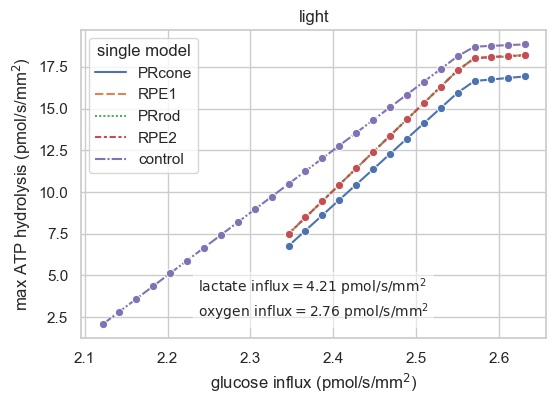

In [333]:
# GLUCOSE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2_single,marker='o',ax=ax)
plt.xlabel('glucose influx (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('light')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx} = 4.21\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 2.76\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.25, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
labels = ['PRcone', 'RPE1', 'PRrod','RPE2','control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
#ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# set x axis limits


def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'light')
fig.savefig(results_folder + '/light_glucose_sweep_SINGLE.png', bbox_inches='tight')
df2_single.to_excel(results_folder + '/light_glucose_sweep_SINGLE.xlsx')  

In [421]:
# DARK
# GLUCOSE SWEEP SINGLE MODELS 

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

#       		 choroid	retinal	total
#   oxygen influx	3.48	0.56	4.04
#	glucose influx	4.14	0.67	4.81
#	lactate efflux	7.18	1.16	8.34


multiplication_factors = [round(x * .01, 2) for x in range(90, 130, 1)]

results_dict_dark = {}

for model in single_models + Human1_models:
    objective_values = []
    with model as m:
        reaction_list = [r.id for r in m.reactions]
        for i in multiplication_factors:
            glucose = (-4.81)*i
            single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                        'MAR09034':(glucose,glucose),\
                        'MAR09135':(8.34,8.34)}
            for ex in single_ex_bounds_dark.keys(): 
                if ex + '_RPE' in reaction_list:
                    model.reactions.get_by_id(ex+ '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif ex + '_PR' in reaction_list:
                    model.reactions.get_by_id(ex+ '_PR').bounds = single_ex_bounds_dark[ex]
                elif ex in reaction_list:
                    model.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
                else:
                    print (ex + ' not in model')
            m.optimize()
            objective_values = objective_values  + [m.objective.value]
        results_dict_dark[m.id] = objective_values

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2')
df2_single_dark = pd.DataFrame(results_dict_dark,index=[m*(4.81) for m in multiplication_factors])


SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2


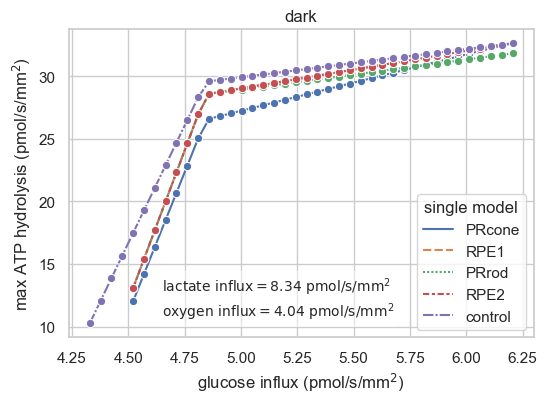

In [423]:
# GLUCOSE SWEEP

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(data=df2_single_dark,marker='o',ax=ax)
plt.xlabel('glucose influx (pmol/s/mm$^2$)')
plt.ylabel('max ATP hydrolysis (pmol/s/mm$^2$)')
plt.title('dark')

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx} = 8.34\ \mathrm{pmol/s/mm}^2$',
    r'$\mathrm{oxygen\ influx} = 4.04\ \mathrm{pmol/s/mm}^2$')) 
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.20, 0.2, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
#handles = [handles[1], handles[0], handles[2]]
labels = ['PRcone', 'RPE1', 'PRrod','RPE2','control']
ax.legend(handles, labels, title='single model')
# move legend outside of plot
#ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# set x axis limits


def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path
    
results_folder = create_folder('results', 'sweep', 'dark')
fig.savefig(results_folder + '/dark_glucose_sweep_SINGLE.png', bbox_inches='tight')
df2_single_dark.to_excel(results_folder + '/dark_glucose_sweep_SINGLE.xlsx')  

In [334]:
##############################################################
##############       for single models      ##################
##############################################################


single_results_dict_dark = {}
single_results_dict_light = {}
for model in single_models:
    with model as m:
        for ex in single_ex_bounds_dark.keys(): 
            # get exchange rxn id
            ex_single=[r.id for r in model.reactions if ex in r.id][0]
            model.reactions.get_by_id(ex_single).bounds = single_ex_bounds_dark[ex] # set exchange bounds
        m.optimize()
        results_dict_dark[m.id] = m.objective.value
        for ex in single_ex_bounds_light.keys(): 
            # get exchange rxn id
            ex_single=[r.id for r in model.reactions if ex in r.id][0]
            model.reactions.get_by_id(ex_single).bounds = single_ex_bounds_light[ex] # set exchange bounds
        m.optimize()
        results_dict_light[m.id] = m.objective.value

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2')
df1 = pd.DataFrame(results_dict_light, index = ['light']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark']).T
results = pd.concat([df1,df2], axis = 1)
results

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


ValueError: Length of values (40) does not match length of index (1)

In [ ]:
##############################################################################
##############     invesitgate why light has no solution    ##################
##############################################################################

def create_stepwise_tuples(start,stop,step):
        """
        this function creates a list of tuples with the same start and stop values, but with a stepwise increase in the values
        """
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]
from src.modify_model import create_permutation_dicts

# set objective function oxygen exchange

for m in model_list:
    if 'MAR09048_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048_PR'
    elif 'MAR09048_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048_RPE'
    elif 'MAR09048' in [r.id for r in m.reactions]:
        m.objective = 'MAR09048'
    else:
        print('no oxygen exchange reaction (MAR09048) in model: ' + m.id)
    m.objective.direction = 'min'
# Force ATP hydrolysis flux, in PR for combined models) to > 1

ATP_bounds = (26.56, 26.56)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR03964_PR').bounds = ATP_bounds
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR03964_RPE').bounds = ATP_bounds
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR03964').bounds = ATP_bounds
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

bounds_oxygen = [(-1000,1000)]
bounds_glucose = create_stepwise_tuples(-4,-1,1)
bounds_lactate = create_stepwise_tuples(3,5,1)
# round up to 2 decimals
bounds_glucose = [(round(i[0],2),round(i[1],2)) for i in bounds_glucose]
bounds_lactate = [(round(i[0],2),round(i[1],2)) for i in bounds_lactate]
ex_bounds = {'MAR09034':bounds_glucose,\
                'MAR09048':bounds_oxygen,\
                'MAR09135':bounds_lactate}
ex_labels = {'glucose':bounds_glucose,\
                'oxygen':bounds_oxygen,\
                'lactate':bounds_lactate}
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)


COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2


,light,dark
mod_RPE_PRcone_Lukowski,None,-0.56
mod_RPE_PRcontrol,None,-0.56
mod_RPE_PRrod_Lukowski,None,-0.56


In [ ]:
model_list[5].reactions.get_by_id('MAR03964_PR')

model_list[5].objective.expression

1.0*MAR09048_PR - 1.0*MAR09048_PR_reverse_ae813

In [ ]:
import warnings
df = pd.DataFrame()

model_list_heatmap = [model_list[5]]

results_dict = {}
for i in range(len(bounds)):
    b = bounds[i]
    l = labels[i]
    for model in model_list_heatmap:
        with model as m:
            warning_filter = 'Solver status is \'infeasible\'' # define filter for specific warning message
            warnings.filterwarnings('ignore', message=warning_filter)     # filter out specific warning message
            set_exchange_bounds(m, b)
            m.optimize()
            results_dict[m.id] = m.objective.value
    df_i = pd.DataFrame(results_dict, index = [str(labels[i]) + ' min oxygen exchange from CC (pmol/s/mm^2)']).T
    df = pd.concat([df,df_i],axis=1)

# lactate and glucose steps (index)
glucose_bounds_df = pd.DataFrame([l['glucose'] for l in labels]).transpose()
lactate_bounds_df = pd.DataFrame([l['lactate'] for l in labels]).transpose()

glucose_bounds_df.index = ['glucose min bound','glucose max bound']
lactate_bounds_df.index = ['lactate min bound','lactate max bound']

gluc_lac_df = pd.concat([glucose_bounds_df,lactate_bounds_df,df.transpose().reset_index().transpose()],axis=0)

# select column 'glucose min bound' and 'lactate min bound' and 'Human-GEM_28062023' 
heatmap_df = gluc_lac_df.transpose()[['glucose min bound', 'lactate min bound', 'mod_RPE_PRrod_Lukowski']].astype(float) # make heatmap with glucose min bound and lactate min bound as x and y axis
heatmap_df = heatmap_df.pivot(index='glucose min bound', columns='lactate min bound', values='mod_RPE_PRrod_Lukowski') # prepare data for heatmap (pivot)


In [ ]:
heatmap_df

lactate min bound,3.0,4.0,5.0
glucose min bound,,,
-4.0,0.0,0.0,0.0
-3.0,0.0,0.0,0.0
-2.0,0.0,NaN,NaN
-1.0,NaN,NaN,NaN


In [ ]:
heatmap_df

lactate min bound,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
glucose min bound,,,,,,,,,,,
-4.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-3.8,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-3.6,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-3.4,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-3.2,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-3.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-2.8,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-2.6,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
-2.4,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,NaN


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (0,) and arg 1 with shape (2,).

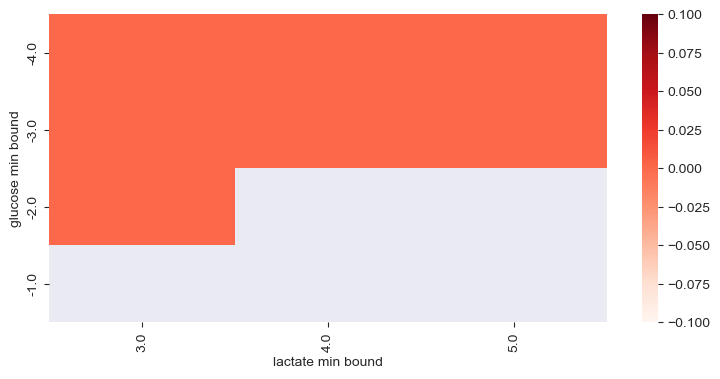

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# figure size
fig = plt.figure(figsize=(9,4))
# reset sns style darkgrid with major xticks
sns.set_style('darkgrid', \
    {'xtick.bottom': True, 'xtick.major.pad': 1.0, 'xtick.major.size': 3.0, 'xtick.major.width': 1.0,\
     'ytick.left': True, 'ytick.major.pad': 1.0, 'ytick.major.size': 3.0, 'ytick.major.width': 1.0})

# plot heatmap
sns.heatmap(heatmap_df,cmap='Reds')

# turn x ticks 90 degrees
plt.xticks(rotation=90)

# draw lines at xtick labels '7.2' and '7.3'
xtick_labels, xtick_positions = plt.xticks() # get xtick labels and positions
xpos1 = [t.get_position()[0]-.5 for t in xtick_positions if t.get_text() == '7.2']
xpos2 = [t.get_position()[0]+.5 for t in xtick_positions if t.get_text() == '7.3']
plt.axvline(x=xpos1, color='white', linestyle='--',linewidth=1.2)
plt.axvline(x=xpos2, color='white', linestyle='--',linewidth=1.2)

# draw lines at ytick labels -4.1 and -4.2
ytick_labels, ytick_positions = plt.yticks() # get ytick labels and positions
ypos1 = [t.get_position()[1]+.5 for t in ytick_positions if t.get_text() == '-4.1']
ypos2 = [t.get_position()[1]-.5 for t in ytick_positions if t.get_text() == '-4.2']
plt.axhline(y=ypos1, color='white', linestyle='--',linewidth=1)
plt.axhline(y=ypos2, color='white', linestyle='--',linewidth=1)

# make all squares perfectly squared
plt.gca().set_aspect('equal', adjustable='box')

# change x and y axis labels
plt.xlabel('lactate exchange (pmol/s/mm$^2$)', fontsize=12)
plt.ylabel('glucose exchange (pmol/s/mm$^2$)', fontsize=12)

# add plt title
plt.title('RPE-PRrod\noptimised oxygen exchange (pmol/s/mm$^2$)')
plt.show()

# save fig in results heatmaps folder 'heatmap_folder'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# figure size
fig = plt.figure(figsize=(9,4))
# reset sns style darkgrid with major xticks
sns.set_style('darkgrid', \
    {'xtick.bottom': True, 'xtick.major.pad': 1.0, 'xtick.major.size': 3.0, 'xtick.major.width': 1.0,\
     'ytick.left': True, 'ytick.major.pad': 1.0, 'ytick.major.size': 3.0, 'ytick.major.width': 1.0})

# plot heatmap
sns.heatmap(heatmap_df,cmap='Reds')

# turn x ticks 90 degrees
plt.xticks(rotation=90)

# draw lines at xtick labels '7.2' and '7.3'
xtick_labels, xtick_positions = plt.xticks() # get xtick labels and positions
xpos1 = [t.get_position()[0]-.5 for t in xtick_positions if t.get_text() == '7.2']
xpos2 = [t.get_position()[0]+.5 for t in xtick_positions if t.get_text() == '7.3']
plt.axvline(x=xpos1, color='white', linestyle='--',linewidth=1.2)
plt.axvline(x=xpos2, color='white', linestyle='--',linewidth=1.2)

# draw lines at ytick labels -4.1 and -4.2
ytick_labels, ytick_positions = plt.yticks() # get ytick labels and positions
ypos1 = [t.get_position()[1]+.5 for t in ytick_positions if t.get_text() == '-4.1']
ypos2 = [t.get_position()[1]-.5 for t in ytick_positions if t.get_text() == '-4.2']
plt.axhline(y=ypos1, color='white', linestyle='--',linewidth=1)
plt.axhline(y=ypos2, color='white', linestyle='--',linewidth=1)

# make all squares perfectly squared
plt.gca().set_aspect('equal', adjustable='box')

# change x and y axis labels
plt.xlabel('lactate exchange (pmol/s/mm$^2$)', fontsize=12)
plt.ylabel('glucose exchange (pmol/s/mm$^2$)', fontsize=12)

# add plt title
plt.title('RPE-PRrod\noptimised oxygen exchange (pmol/s/mm$^2$)')
plt.show()

# save fig in results heatmaps folder 

In [ ]:
gluc_lac_df

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
glucose min bound,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
glucose max bound,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
lactate min bound,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,...,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
lactate max bound,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,...,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
level_0,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
glucose min bound,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
glucose max bound,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
lactate min bound,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,...,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
lactate max bound,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,...,3.2,3.4,3.6,3.8,4.0,4.2,4.4,4.6,4.8,5.0
index,"{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...","{'glucose': (-4.0, -4.0), 'oxygen': (-1000, 10...",...,"{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10...","{'glucose': (-1.0, -1.0), 'oxygen': (-1000, 10..."


In [ ]:
# lactate and glucose steps (index)
glucose_bounds_df = pd.DataFrame([l['glucose'] for l in labels]).transpose()
lactate_bounds_df = pd.DataFrame([l['lactate'] for l in labels]).transpose()

glucose_bounds_df.index = ['glucose min bound','glucose max bound']
lactate_bounds_df.index = ['lactate min bound','lactate max bound']

gluc_lac_df = pd.concat([glucose_bounds_df,lactate_bounds_df,df.transpose().reset_index().transpose()],axis=0)

# select column 'glucose min bound' and 'lactate min bound' and 'Human-GEM_28062023' 
heatmap_df = gluc_lac_df.transpose()[['glucose min bound', 'lactate min bound', 'Human-GEM_28062023']].astype(float) # make heatmap with glucose min bound and lactate min bound as x and y axis
heatmap_df = heatmap_df.pivot(index='glucose min bound', columns='lactate min bound', values='Human-GEM_28062023') # prepare data for heatmap (pivot)


ValueError: Length of values (176) does not match length of index (2)

In [ ]:

############################
# mod_RPE_PRrod_Lukowski ###
############################


bounds_oxygen = [(-1000,1000)]
bounds_glucose = create_stepwise_tuples(-5,-3.5,.1)
bounds_lactate = create_stepwise_tuples(6,9,.1)
# round numbers to 1 decimal place in tuple list
bounds_glucose = [tuple([round(num,1) for num in tup]) for tup in bounds_glucose]
bounds_lactate = [tuple([round(num,1) for num in tup]) for tup in bounds_lactate]

ex_bounds = {'MAR09034':bounds_glucose,\
                'MAR09048':bounds_oxygen,\
                'MAR09135':bounds_lactate}
ex_labels = {'glucose':bounds_glucose,\
                'oxygen':bounds_oxygen,\
                'lactate':bounds_lactate}
bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

df = pd.DataFrame()
results_dict = {}
for i in range(len(bounds)):
    b = bounds[i]
    l = labels[i]
    for m in [model_list[-5]]:
        warning_filter = 'Solver status is \'infeasible\'' # define filter for specific warning message
        warnings.filterwarnings('ignore', message=warning_filter)     # filter out specific warning message
        set_exchange_bounds(m, b)
        m.optimize()
        results_dict[m.id] = m.objective.value
    df_i = pd.DataFrame(results_dict, index = [str(labels[i]) + ' min oxygen exchange from CC (pmol/s/mm^2)']).T
    df = pd.concat([df,df_i],axis=1)

# lactate and glucose steps (index)
glucose_bounds_df = pd.DataFrame([l['glucose'] for l in labels]).transpose()
lactate_bounds_df = pd.DataFrame([l['lactate'] for l in labels]).transpose()

glucose_bounds_df.index = ['glucose min bound','glucose max bound']
lactate_bounds_df.index = ['lactate min bound','lactate max bound']

gluc_lac_df = pd.concat([glucose_bounds_df,lactate_bounds_df,df.transpose().reset_index().transpose()],axis=0)

# select column 'glucose min bound' and 'lactate min bound' and 'Human-GEM_28062023' 
heatmap_df = gluc_lac_df.transpose()[['glucose min bound', 'lactate min bound', 'mod_RPE_PRrod_Lukowski']].astype(float) # make heatmap with glucose min bound and lactate min bound as x and y axis
heatmap_df = heatmap_df.pivot(index='glucose min bound', columns='lactate min bound', values='mod_RPE_PRrod_Lukowski') # prepare data for heatmap (pivot)

# save heatmap_df as excel in results/heatmaps/mod_RPE_PRrod_Lukowski
heatmap_df.to_excel(os.path.join(heatmap_folder, 'mod_RPE_PRrod_Lukowski','heatmap_optimise_oxygen_exchange_mod_RPE_PRrod_Lukowski.xlsx'))


In [ ]:
# write results to excel file in results folder 
# create results/heatmaps/Human-GEM_28062023 in user folder
results_folder = os.path.join(os.path.expanduser('~'), 'results', 'paper','optimise ATP hydrolysis', 'light/dark')
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# save heatmap_df as excel in results/heatmaps/Human-GEM_28062023
results.to_excel(os.path.join(results_folder, 'combined_models.xlsx'))

In [ ]:
combined_models

[<Model mod_RPE_PRcone_Lukowski at 0x25a3862b8b0>,
 <Model mod_RPE_PRcontrol at 0x25a3a70c070>,
 <Model mod_RPE_PRrod_Lukowski at 0x25b020a3460>]

In [ ]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)
from src.modify_model import set_exchange_bounds
RPE_ex_bounds_dark = {'MAR09048':(-3.51,-3.51),'MAR09034':(-4.18,-4.18),'MAR09135':(7.25,7.25)}
RPE_ex_bounds_light = {'MAR09048':(-2.61,-2.61),'MAR09034':(-1.93,-1.93),'MAR09135':(3.98,3.98)}

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 
# MAR09047 water
for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
    r.bounds=(0,1000)

results_dict_dark = {}
results_dict_light = {}
for model in single_models:
    with model as m:
        set_exchange_bounds(m, RPE_ex_bounds_dark, 'RPE')
        m.optimize()
        results_dict_dark[m.id] = m.objective.value
        for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
            r.bounds=(0,1000)
        set_exchange_bounds(m, RPE_ex_bounds_light, 'RPE')
        m.optimize()
        results_dict_light[m.id] = m.objective.value
        for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
            r.bounds=(0,1000)


df1 = pd.DataFrame(results_dict_light, index = ['light']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark']).T
pd.concat([df1,df2], axis = 1)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light,dark
mod_RPE_PRcone_Lukowski_singlePR,None,21.695
mod_RPE_PRcone_Lukowski_singleRPE,None,23.360
mod_RPE_PRrod_Lukowski_singlePR,None,23.360
mod_RPE_PRrod_Lukowski_singleRPE,None,23.900


In [ ]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)
from src.modify_model import set_exchange_bounds
RPE_ex_bounds_dark = {'MAR09048':(-3.51,-3.51),'MAR09034':(-4.18,-4.18),'MAR09135':(7.25,7.25)}
RPE_ex_bounds_light = {'MAR09048':(-2.61,-2.61),'MAR09034':(-1.93,-1.93),'MAR09135':(3.98,3.98)}

RPE_ex_bounds_dark = {'MAR09047':(-1000,1000),\
                      'MAR09048':(-4.04,-4.04),\
                      'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(8.34,8.34)}
RPE_ex_bounds_light = {'MAR09047':(-1000,1000),\
                       'MAR09048':(-2.76,-2.76),\
                       'MAR09034':(-2.05,-2.05),\
                        'MAR09135':(4.21,4.21)}
# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 2.05

# MAR09047 water
for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
    r.bounds=(0,1000)
results_dict_dark = {}
results_dict_light = {}
for m in model_list:
    set_exchange_bounds(m, RPE_ex_bounds_dark, 'RPE')
    m.optimize()
    results_dict_dark[m.id] = m.objective.value
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)
    set_exchange_bounds(m, RPE_ex_bounds_light, 'RPE')
    m.optimize()
    results_dict_light[m.id] = m.objective.value
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)
print('\n \nINITIAL RESULTS (OLD NEW ESTIMATES)')
df1 = pd.DataFrame(results_dict_light, index = ['light - max ATP hydrolysis (pmol/s/mm^2)']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark - max ATP hydrolysis (pmol/s/mm^2)']).T
pd.concat([df1,df2], axis = 1)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u


 
INITIAL RESULTS (OLD NEW ESTIMATES)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light - max ATP hydrolysis (pmol/s/mm^2),dark - max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,None,28.30
mod_RPE_PRcone_Lukowski,None,28.50
mod_RPE_PRcone_Lukowski_singlePR,None,25.02
mod_RPE_PRcone_Lukowski_singleRPE,None,26.94
mod_RPE_PRcontrol,None,28.50
mod_RPE_PRrod_Lukowski,None,28.50
mod_RPE_PRrod_Lukowski_singlePR,None,26.94
mod_RPE_PRrod_Lukowski_singleRPE,None,27.54


In [ ]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)
from src.modify_model import set_exchange_bounds
RPE_ex_bounds_dark = {'MAR09048':(-3.51,-3.51),'MAR09034':(-4.18,-4.18),'MAR09135':(7.25,7.25)}
RPE_ex_bounds_light = {'MAR09048':(-2.61,-2.61),'MAR09034':(-1.93,-1.93),'MAR09135':(3.98,3.98)}

RPE_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                      'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(8.34,8.34)}
RPE_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                       'MAR09034':(-2.05,-2.05),\
                        'MAR09135':(4.21,4.21)}
# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 2.05

# MAR09047 water
for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
    r.bounds=(0,1000)
    
results_dict_dark = {}
results_dict_light = {}
for m in model_list:
    set_exchange_bounds(m, RPE_ex_bounds_dark, 'RPE')
    m.optimize()
    results_dict_dark[m.id] = m.objective.value
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)
    set_exchange_bounds(m, RPE_ex_bounds_light, 'RPE')
    m.optimize()
    results_dict_light[m.id] = m.objective.value
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)
print('\n \nINITIAL RESULTS (OLD NEW ESTIMATES)')
df1 = pd.DataFrame(results_dict_light, index = ['light - max ATP hydrolysis (pmol/s/mm^2)']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark - max ATP hydrolysis (pmol/s/mm^2)']).T
pd.concat([df1,df2], axis = 1)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u


 
INITIAL RESULTS (OLD NEW ESTIMATES)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light - max ATP hydrolysis (pmol/s/mm^2),dark - max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,None,28.30
mod_RPE_PRcone_Lukowski,None,28.50
mod_RPE_PRcone_Lukowski_singlePR,None,25.62
mod_RPE_PRcone_Lukowski_singleRPE,None,27.54
mod_RPE_PRcontrol,None,28.50
mod_RPE_PRrod_Lukowski,None,28.50
mod_RPE_PRrod_Lukowski_singlePR,None,27.54
mod_RPE_PRrod_Lukowski_singleRPE,None,27.54


In [ ]:
# OPEN EFFLUX FOR ALL EXCHANGE REACTIONS in  combined models (so also PR exchange)
for m in model_list:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

RPE_ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}
# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 
        
results_dict = {}
for m in model_list:
    set_exchange_bounds(m, RPE_ex_bounds, 'RPE')
    m.optimize()
    results_dict[m.id] = m.objective.value
print('\n \nPR EFFLUX OPENED AS WELL')
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1


 
PR EFFLUX OPENED AS WELL


,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Lukowski,24.7325
mod_RPE_PRrod_Lukowski_singlePR,23.9000
mod_RPE_PRrod_Lukowski_singleRPE,23.9000
